### Get OOT validation of ACH
---

The performance of ACH makes me wonder if we have data leakage. Let's double check

In [1]:
import json
import pandas as pd
import numpy as np
import pickle as pkl
from rdsutils.aws import download_s3 #, python_object_to_s3
from rdsutils.lightgbm_helpers import train_lgb_baseline_grouped
import rdsutils.plot as rdsplot

import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('ggplot')
%load_ext autoreload
%autoreload 2

In [10]:
modeling_df = pd.read_parquet('../../artifacts/20201005/modeling_df_w_baseline_preds.parquet')
test_df = pd.read_parquet('../../artifacts/20201005/test_df.parquet')
modeling_df.shape, test_df.shape

((112599, 214), (88890, 207))

In [11]:
modeling_df['account_ending_balance'] = modeling_df['real_ending_balance']
modeling_df['days_since_first_transaction'] = modeling_df['days_since_first_deposit']
modeling_df['ach_target'] = modeling_df['is_returned']

test_df['account_ending_balance'] = test_df['real_ending_balance']
test_df['days_since_first_transaction'] = test_df['days_since_first_deposit']
test_df['ach_target'] = test_df['is_returned']

In [12]:
features = pkl.load(open('../../artifacts/20201005/features_corr_removed.pkl', 'rb'))
print(len(features))

26


In [13]:
seed = 12345

target_col = 'ach_target'
count_pos = modeling_df[target_col].sum()
count_neg = (~modeling_df[target_col]).sum()
pos_wgt_scaling_factor = count_neg / count_pos

params = {
    "objective" : "binary",
    "metric" : "auc",
    "boosting": 'gbdt',
    "max_depth" : 3,
    "num_leaves" : 10,
    "learning_rate" : 0.02,
    "feature_fraction" : 0.6,
    "lambda_l1": 10,
    "lambda_l2": 10, 
    "min_data_in_leaf": 50,
    "scale_pos_weight": pos_wgt_scaling_factor,
    "tree_learner": "serial",
    "boost_from_average": "false",
    "bagging_seed" : seed,
    "verbosity" : -1,
    "seed": seed
}

import json

with open('../../artifacts/20201005/final_lgbm_params.json', 'r') as f:
    params_autogluon = json.load(f)

for p in params_autogluon:
    params[p] = params_autogluon[p]
    
display(params)

{'objective': 'binary',
 'metric': 'auc',
 'boosting': 'gbdt',
 'max_depth': 5,
 'num_leaves': 18,
 'learning_rate': 0.06251310567064901,
 'feature_fraction': 0.8,
 'lambda_l1': 0.0,
 'lambda_l2': 6.864384204691345,
 'min_data_in_leaf': 21,
 'scale_pos_weight': 28.893362831858408,
 'tree_learner': 'serial',
 'boost_from_average': 'false',
 'bagging_seed': 12345,
 'verbosity': -1,
 'seed': 12345,
 'num_boost_round': 2000,
 'num_threads': 16,
 'verbose': -1,
 'boosting_type': 'gbdt',
 'two_round': True,
 'seed_value': None}

In [14]:
from rdsutils.lightgbm_helpers import train_validate_lgb

In [15]:
result = train_validate_lgb(modeling_df, test_df, 
                   features=features, params=params,
                   target_col_name=target_col)

/home/ec2-user/anaconda3/envs/ml_basic_py37/lib/python3.7/site-packages/lightgbm/engine.py:151: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] verbosity is set=-1, verbose=-1 will be ignored. Current value: verbosity=-1
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
Training until validation scores don't improve for 500 rounds
[500]	train's auc: 0.987705	test's auc: 0.931023
Early stopping, best iteration is:
[267]	train's auc: 0.976777	test's auc: 0.931947


In [16]:
pred, fimp, model, auc = result

(<Figure size 432x288 with 1 Axes>,
 <AxesSubplot:title={'center':'2-class AUC ROC curve: AUC = 0.93194694662948'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>)

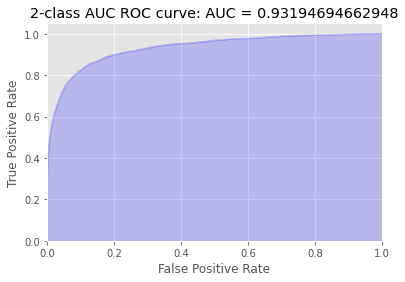

In [17]:
rdsplot.plot_auc_curve(pred, test_df[target_col])

(<Figure size 432x288 with 1 Axes>,
 <AxesSubplot:title={'center':'2-class Precision-Recall curve: AP = 0.6654933193800592'}, xlabel='Recall', ylabel='Precision'>)

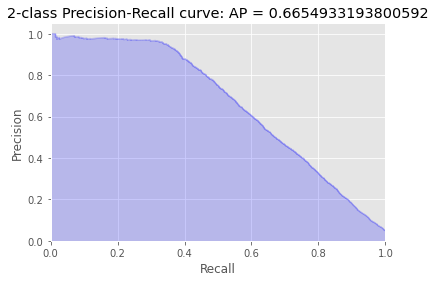

In [18]:
rdsplot.plot_pr_curve(pred, test_df[target_col])

In [26]:
with open('../../artifacts/20201005/final_model_objects.pkl', 'wb') as f:
    package = {'test_pred': pred, 
               'fimp': fimp, 
               'model': model,
               'auc': auc, 
               'params': params}
    pkl.dump(package, f)

### Try with full ACH data

In [20]:
ach_df = pd.read_parquet('../../artifacts/20201005/ach_df_full.parquet')

<AxesSubplot:>

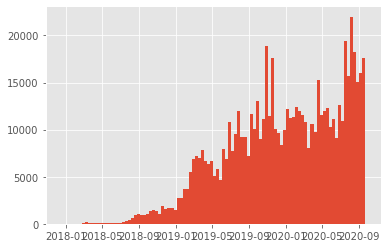

In [21]:
ach_df.transaction_datetime.hist(bins=100)

In [22]:
ach_df['account_ending_balance'] = ach_df['real_ending_balance']
ach_df['days_since_first_transaction'] = ach_df['days_since_first_deposit']
ach_df['ach_target'] = ach_df['is_returned']

In [23]:
out, bins = pd.qcut(modeling_df.transaction_datetime, 
                    [0, 0.2, 0.4, 0.6, 0.8, 1], retbins=True)

2020-05-01 18:01:06 2020-05-19 18:01:09 2020-06-09 18:01:07


/home/ec2-user/anaconda3/envs/ml_basic_py37/lib/python3.7/site-packages/lightgbm/engine.py:151: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] verbosity is set=-1, verbose=-1 will be ignored. Current value: verbosity=-1
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
Training until validation scores don't improve for 500 rounds
[500]	train's auc: 0.999782	test's auc: 0.909738
Early stopping, best iteration is:
[94]	train's auc: 0.985387	test's auc: 0.916775
--------------------------------------------------------------------------------
AUC Curve
PR Curve


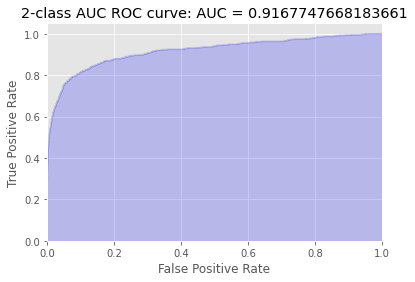

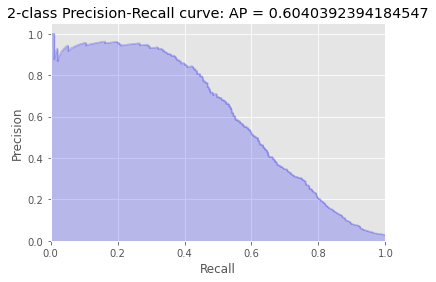

2020-05-19 18:01:09 2020-06-09 18:01:07 2020-06-30 18:01:29
[LightGBM] [Warning] verbosity is set=-1, verbose=-1 will be ignored. Current value: verbosity=-1
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt


/home/ec2-user/anaconda3/envs/ml_basic_py37/lib/python3.7/site-packages/lightgbm/engine.py:151: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 500 rounds
[500]	train's auc: 0.999772	test's auc: 0.898192
Early stopping, best iteration is:
[42]	train's auc: 0.972809	test's auc: 0.91417
--------------------------------------------------------------------------------
AUC Curve
PR Curve


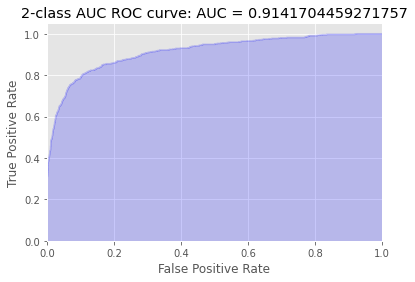

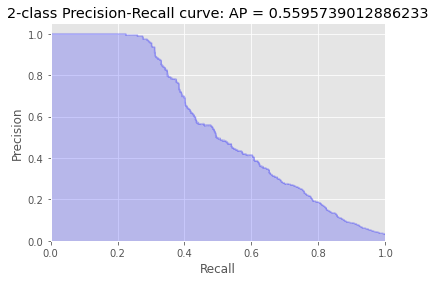

2020-06-09 18:01:07 2020-06-30 18:01:29 2020-07-16 18:01:37
[LightGBM] [Warning] verbosity is set=-1, verbose=-1 will be ignored. Current value: verbosity=-1
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt


/home/ec2-user/anaconda3/envs/ml_basic_py37/lib/python3.7/site-packages/lightgbm/engine.py:151: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 500 rounds
[500]	train's auc: 0.999627	test's auc: 0.912342
Early stopping, best iteration is:
[124]	train's auc: 0.987178	test's auc: 0.915283
--------------------------------------------------------------------------------
AUC Curve
PR Curve


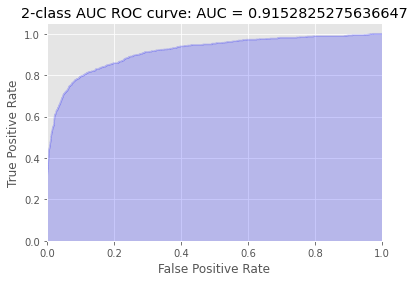

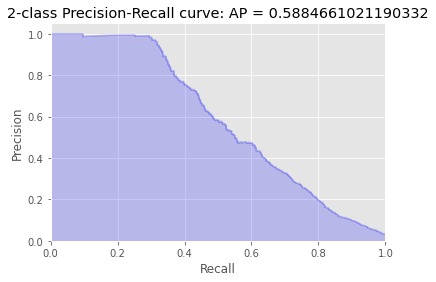

2020-06-30 18:01:29 2020-07-16 18:01:37 2020-07-30 18:01:11
[LightGBM] [Warning] verbosity is set=-1, verbose=-1 will be ignored. Current value: verbosity=-1
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
Training until validation scores don't improve for 500 rounds


/home/ec2-user/anaconda3/envs/ml_basic_py37/lib/python3.7/site-packages/lightgbm/engine.py:151: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[500]	train's auc: 0.999351	test's auc: 0.929062
Early stopping, best iteration is:
[139]	train's auc: 0.986834	test's auc: 0.933896
--------------------------------------------------------------------------------
AUC Curve
PR Curve


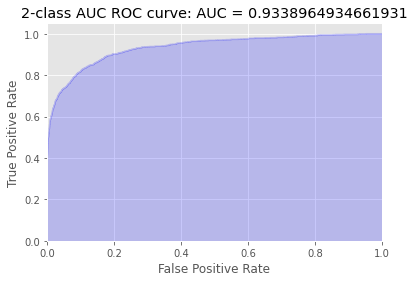

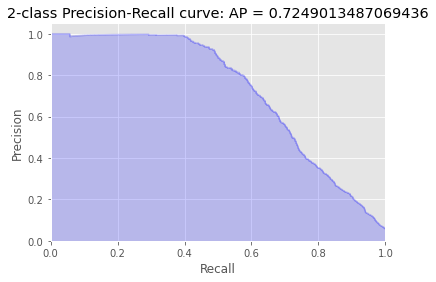

In [24]:
for (start, mid, end) in zip(bins[:-2], bins[1:-1], bins[2:]):
    print(start, mid, end)
    train_df_ = ach_df[ach_df.transaction_datetime.between(start, mid)]
    test_df_ = ach_df[ach_df.transaction_datetime.between(mid, end)]
    
    result = train_validate_lgb(train_df_, test_df_, 
                               features=boruta_features, params=params,
                               target_col_name=target_col)
    
    pred, fimp, model, auc = result
    print('-' * 80)
    print("AUC Curve")
    rdsplot.plot_auc_curve(pred, test_df_[target_col])
    print("PR Curve")
    rdsplot.plot_pr_curve(pred, test_df_[target_col])
    
    plt.show()

<AxesSubplot:>

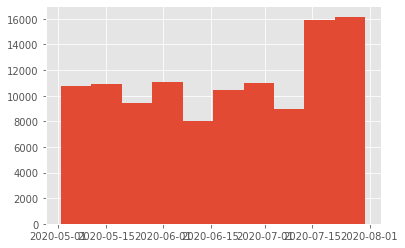

In [25]:
modeling_df.transaction_datetime.hist()